# **Import Libraries and modules**

In [0]:
# https://keras.io/
!pip install -q keras
import keras

In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [0]:
from google.colab import files

In [0]:
from google.colab import drive

In [6]:
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab_Models/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras.datasets import mnist

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.callbacks import LearningRateScheduler

In [0]:
from keras.preprocessing.image import ImageDataGenerator

### Load pre-shuffled MNIST data into train and test sets

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


(60000, 28, 28)


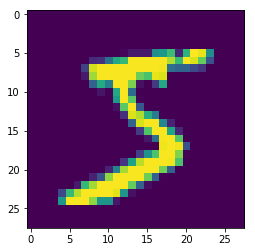

In [12]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

- Standardizing the images (dividing by 255)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [15]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [17]:
Y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (X_train.mean(), X_train.std(), X_test.mean(), X_test.std()))

Statistics train=0.131 (0.308), test=0.133 (0.310)


###Image Normalization using ImageDataGenerator
- **featurewise** - the statistics(mean and standard deviation) for the normalization is calculated using the entire dataset
- **samplewise** - the statistics are calculated using pixel values in each image


- **centering** : scale pixel values to have zero mean
- **std_normalization** : scale pixels to have unit variance  

We will be using featurewise center and featurewise std_normalization


In [0]:
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(X_train)

In [20]:
print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

Data Generator mean=0.131, std=0.308


In [21]:
train_iterator = datagen.flow(X_train, Y_train, batch_size=32)
batchX, batchy = train_iterator.next()
print(batchX.shape, batchX.mean(), batchX.std(), batchX.min(), batchX.max())

(32, 28, 28, 1) -0.011003728 0.9798813 -0.42407304 2.821534


In [0]:
val_iterator = datagen.flow(X_test, Y_test)

In [32]:
print('Batches train=%d, val=%d' % (len(train_iterator), len(val_iterator)))

Batches train=1875, val=313


###  1) L2 Regularization with lambda=1

###  2) Adding ReLU after BN

In [24]:
import keras.backend as K

def custom_loss(lambd):
  def reg_term(lambd):
    w2 = 0
    for i in range(len(model.layers)):
      if len(model.layers[i].get_weights())>0:
        t = np.sum(model.layers[i].get_weights()[0] * model.layers[i].get_weights()[0])
        w2 = w2+t
      w2 = w2*(lambd/(2*X_train.shape[0]))
    return w2

  # Define custom loss
  def loss_l2(y_true, y_pred):
      return K.categorical_crossentropy(y_true, y_pred) + reg_term(lambd)
    
  return loss_l2

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

from keras.layers import Activation
from keras.optimizers import Adam
model = Sequential()

 
model.add(Convolution2D(8, 3, 3, input_shape=(28,28,1))) # 26
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))

model.add(Convolution2D(16, 3, 3)) # 24
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(Convolution2D(24, 3, 3)) # 22
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.05))

model.add(MaxPooling2D(pool_size=(2, 2))) # 11
model.add(Convolution2D(8, 1, 1)) # 11
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))

model.add(Convolution2D(16, 3, 3)) # 9
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(Convolution2D(24, 3, 3)) # 7
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.05))

model.add(Convolution2D(10, 1)) #7
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(Convolution2D(10, 7))
model.add(Flatten())
model.add(Activation('softmax'))

model.summary()
model.compile(loss=custom_loss(1),
             optimizer=Adam(lr=0.003),
             metrics=['accuracy'])
checkpoint = ModelCheckpoint(root_path+'model_assignment_5f.h5', save_best_only=True,monitor='val_acc')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), input_shape=(28, 28, 1...)`



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3))`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3))`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 16)       

In [0]:
model.fit_generator(train_iterator, validation_data=val_iterator, epochs=40, validation_freq=1, verbose=1, callbacks=[LearningRateScheduler(scheduler, verbose=1),checkpoint])

Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
1875/1875 [==============================] - 35s 19ms/step - loss: 0.1349 - acc: 0.9587 - val_loss: 0.0551 - val_acc: 0.9821
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0582 - acc: 0.9819 - val_loss: 0.0375 - val_acc: 0.9876
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0445 - acc: 0.9866 - val_loss: 0.0310 - val_acc: 0.9901
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0374 - acc: 0.9884 - val_loss: 0.0343 - val_acc: 0.9889
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0336 - a

Model accuracy 99.49 (28th epoch)

###Printing misclassified images

In [0]:
val_iterator_no_shuffle = datagen.flow(X_test, Y_test, shuffle=False)

prediction = np.round(model.predict_generator(val_iterator_no_shuffle))

from numpy import argmax
Y_test_=argmax(Y_test, axis=1)
prediction_ = argmax(prediction, axis=1)

wrong_prediction_indices = (prediction_ != Y_test_)

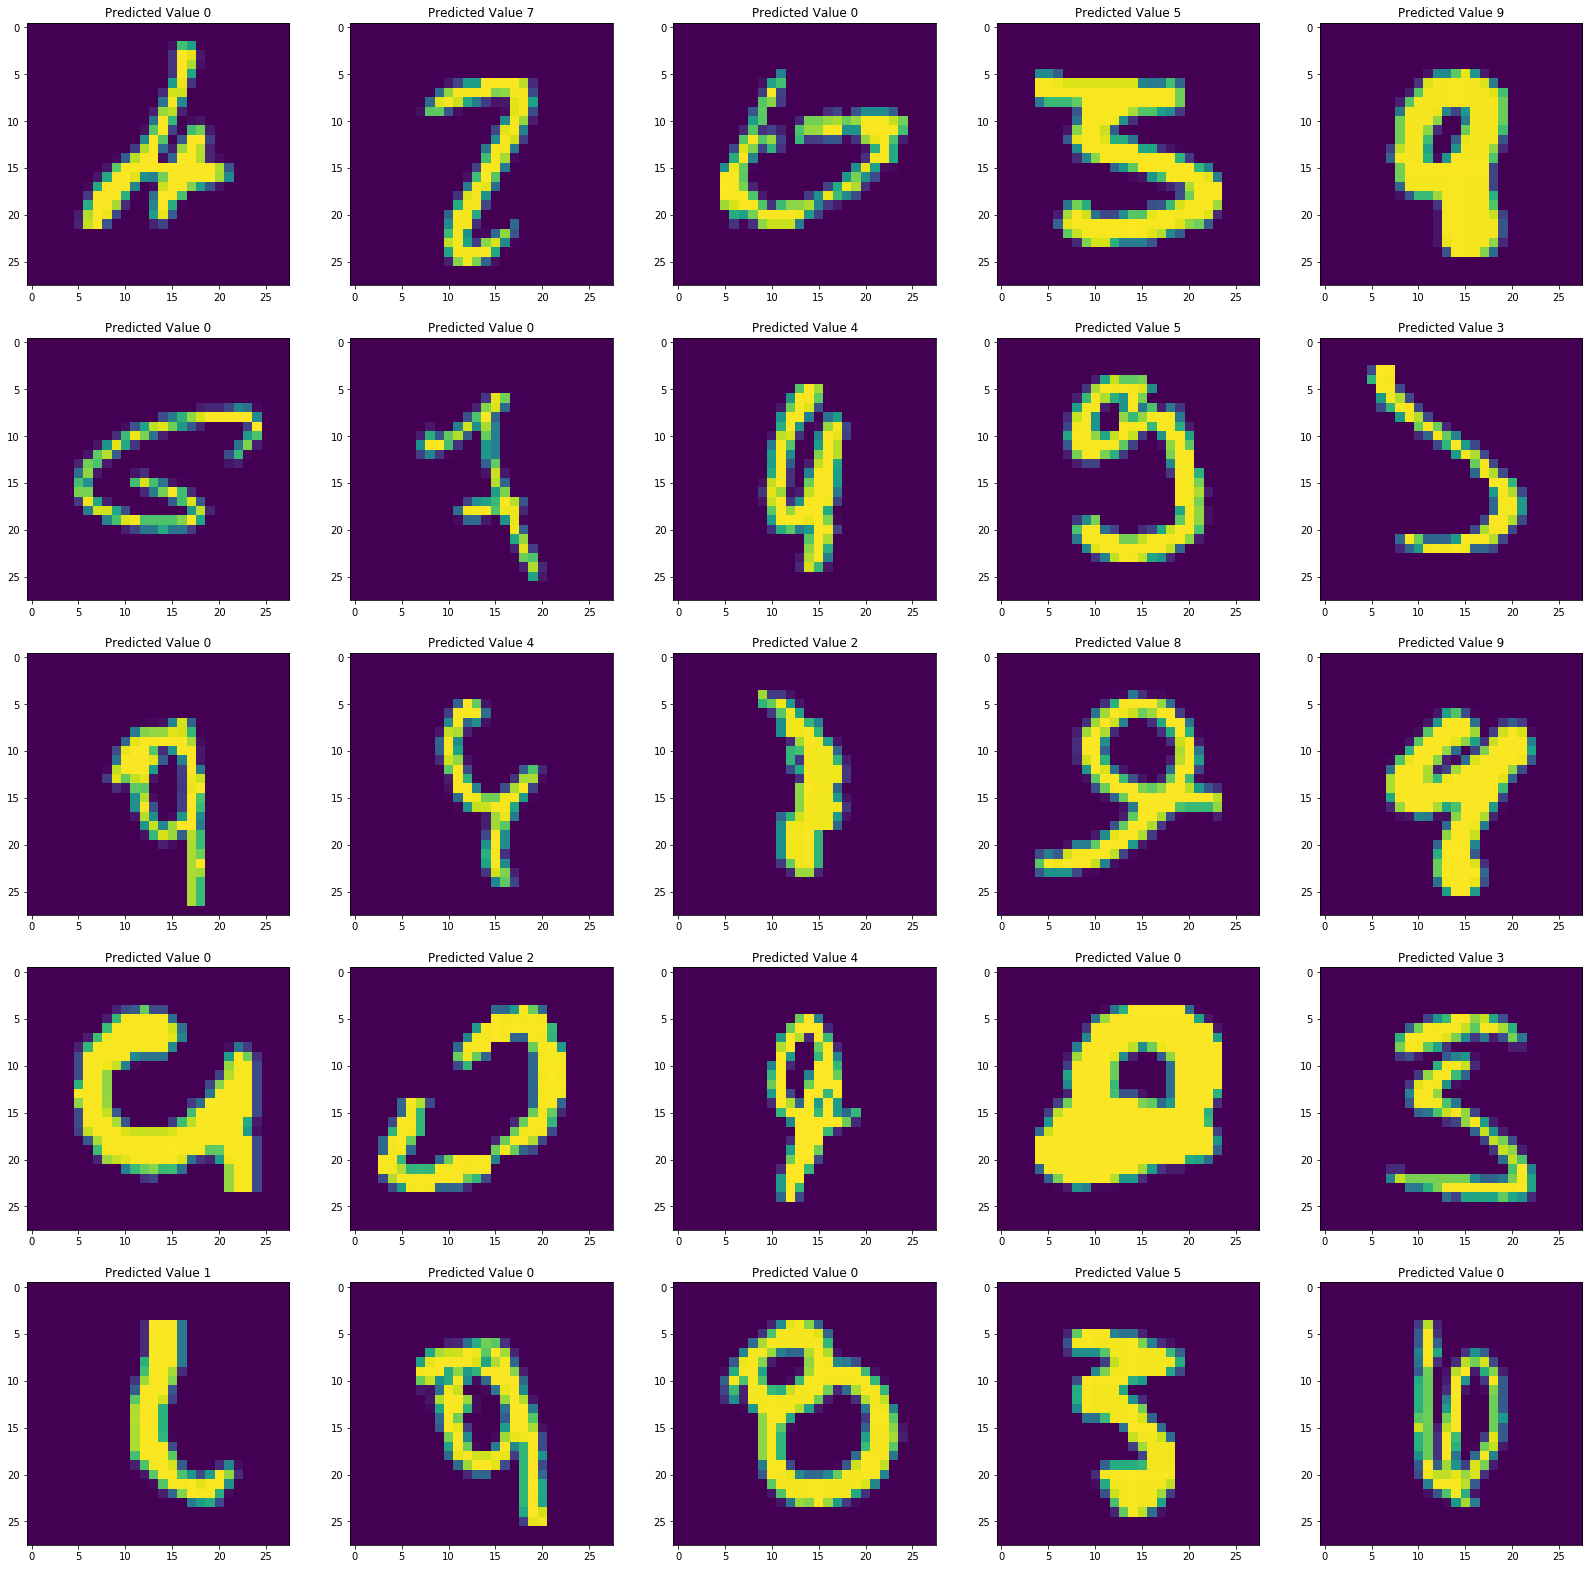

In [26]:
plot_x, plot_y = 5, 5
fig, ax = plt.subplots(plot_x, plot_y, figsize = (28, 28))

misclassification_count = 0
x = 0
y = 0
for index, value in enumerate(wrong_prediction_indices):
  if(value):
    ax[x, y].imshow(X_test[index].reshape(28,28))
    ax[x, y].set_title('Predicted Value %d' % (prediction_[index]))
    misclassification_count = misclassification_count+1
    if(x<5 and y<4):
      y = y+1
    elif(x<4 and y==4):
      x = x+1
      y = 0
    
    if(misclassification_count==25):
      break